# Importing requiered libraires and modules

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
import numpy as np
from matplotlib.widgets import MultiCursor

import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage
from moviepy.editor import VideoFileClip, VideoClip, clips_array,ImageSequenceClip

photometry_lib = "/home/thomas.topilko/Documents/Fiber_Photometry_Analysis"

if os.getcwd() != photometry_lib :
    os.chdir(photometry_lib)
    
import IO as io
import Utilities as ut
import Signal_Preprocessing as spp
import Behavior_Preprocessing as bpp
import Parameters as p
import Plot as plot
import Video_Plot as v_plot

# Set working directory and files

In [2]:
experiment = "yymmdd"
mouse = "test"

working_directory = os.path.join(photometry_lib, "Test/{0}/{1}".format(experiment, mouse))

files = ut.set_file_paths(working_directory, experiment, mouse)
photometry_file_csv, video_file, behavior_automatic_file, behavior_manual_file, saving_directory = files



/home/thomas.topilko/Documents/Fiber_Photometry_Analysis/Test/yymmdd/test/photometry_yymmdd_test.csv was correctly detected
/home/thomas.topilko/Documents/Fiber_Photometry_Analysis/Test/yymmdd/test/video_yymmdd_test.avi was correctly detected
[WARNING] /home/thomas.topilko/Documents/Fiber_Photometry_Analysis/Test/yymmdd/test/behavior_automatic_yymmdd_test.npy does not exist!
/home/thomas.topilko/Documents/Fiber_Photometry_Analysis/Test/yymmdd/test/behavior_manual_yymmdd_test.xlsx was correctly detected


# Loads the parameters

In [3]:
args = p.set_parameters(files, allow_downsampling=True) #Loads all the parameters for the analysis

Lenght of recording : 360s, estimated sampling rate of the system : 241


Parameters loaded successfully


If you like to change some of the parameters you can directly modify them in
the 'Parameters.py' file or change them by calling : 'args['arg'] = new_value' with
arg corresponding to the argument you desire to change, and new_value the new value
of the argument in question


Extract the raw Isosbestic and Calcium data and displays it

In [4]:
photometry_file_npy = io.convert_to_npy(photometry_file_csv, **args) #Convert CSV file to NPY if needed

Converting CSV photometry data into NPY
Filetered : 0 points


# Pre-processing of the photometry data

The pre-processing pipeline is subdivided in 6 major steps.
Each of these steps generate (if wanted) a representative plot of what the pipeline performs.
By default, all steps are set to generate a plot. To access or modify the plotting parameters, type and modify its values :

In [5]:
args["photometry_pp"]["plots_to_display"] #Display all the parameters for plotting
args["photometry_pp"]["plots_to_display"]["standardization"] = True  #Modify a value

## Load the raw data

The first step of the pre-processing pipeline is obviously to load the raw data from the file containing the recordings.
The function _spp.extract_raw_data_ allows you to do that.


Extracting raw data for Isosbestic and Calcium recordings !


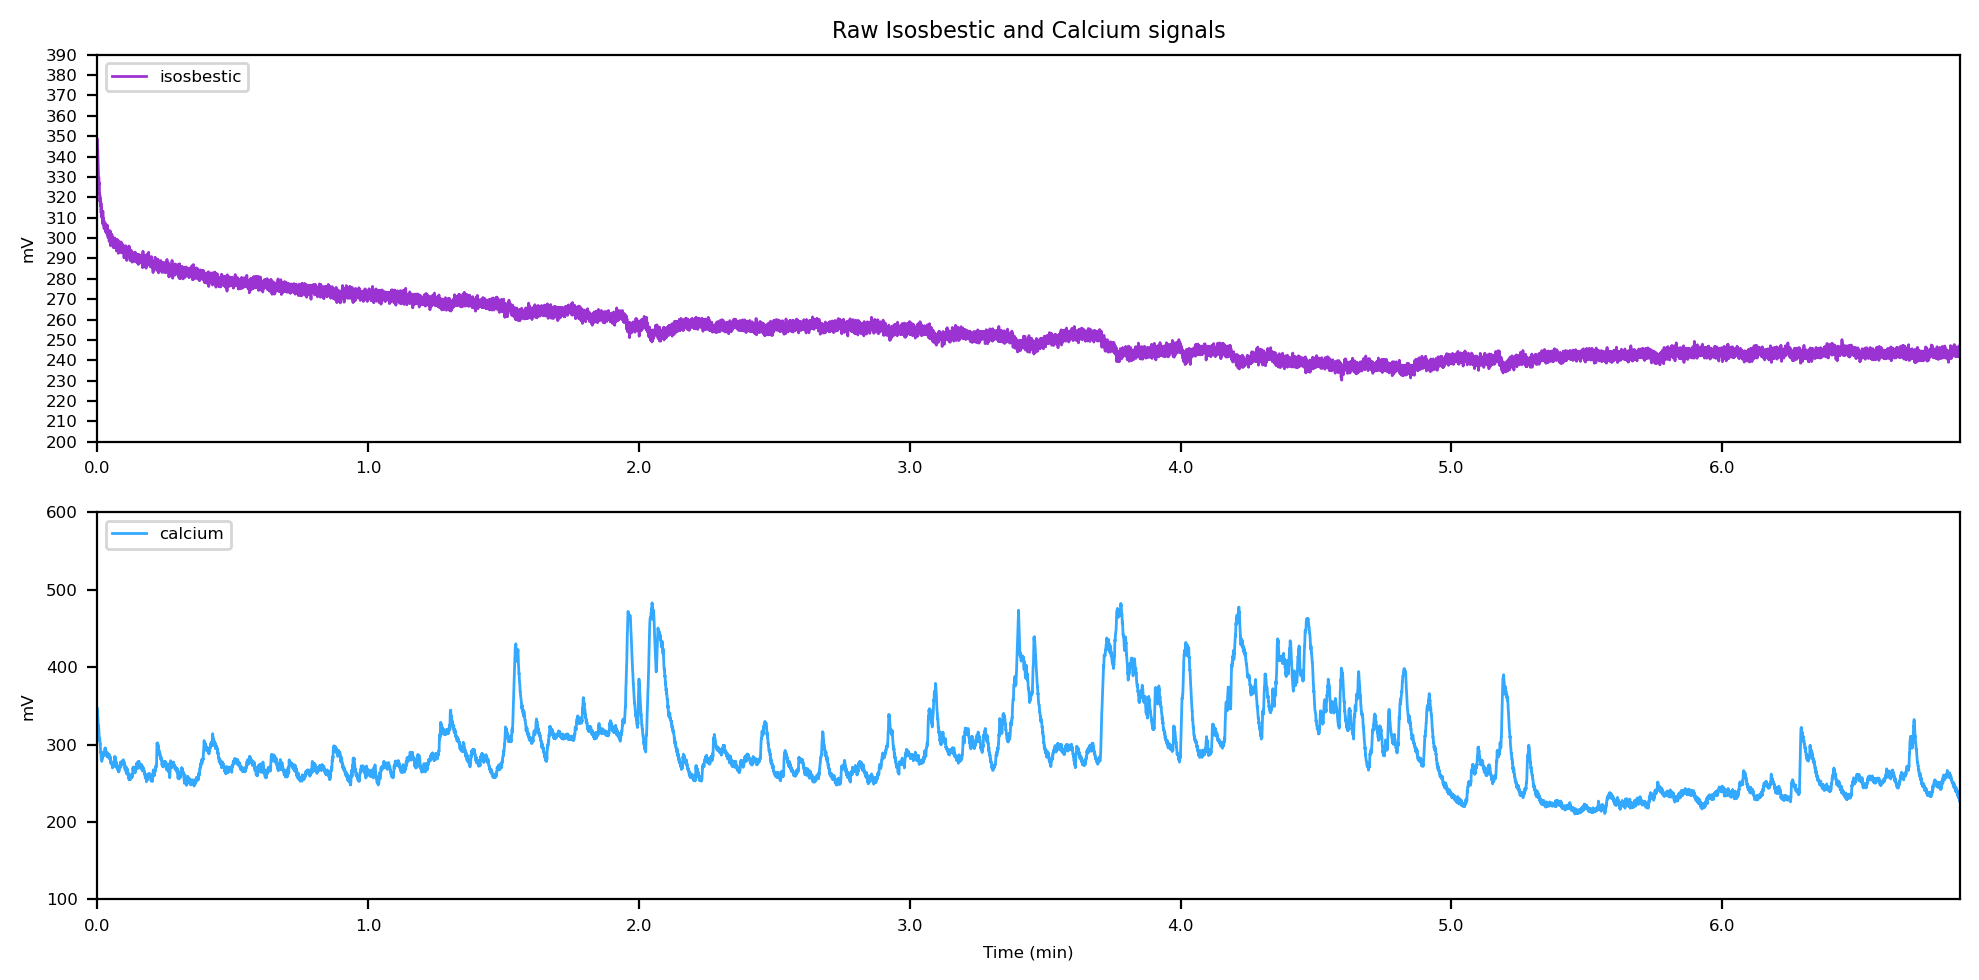

In [6]:
x0, isosbestic, calcium = spp.extract_raw_data(photometry_file_npy, **args) #Loads and plots the raw data

## Smoothing of the data

The second step of the pre-processing pipeline is to smooth the data to decrease high frequency noise.
The function _spp.smooth_ allows you to do that. The main parameters to modify here is located in args["smoothing_window"] which corresponds to the size of the window used for smoothing.
This value is by default set to be equal to the sampling rate of the recording (usually 250Hz = 1s equivalent). Increasing this parameter will smooth even more the signal and vice versa.


Starting smoothing for Isosbestic and Calcium signals !


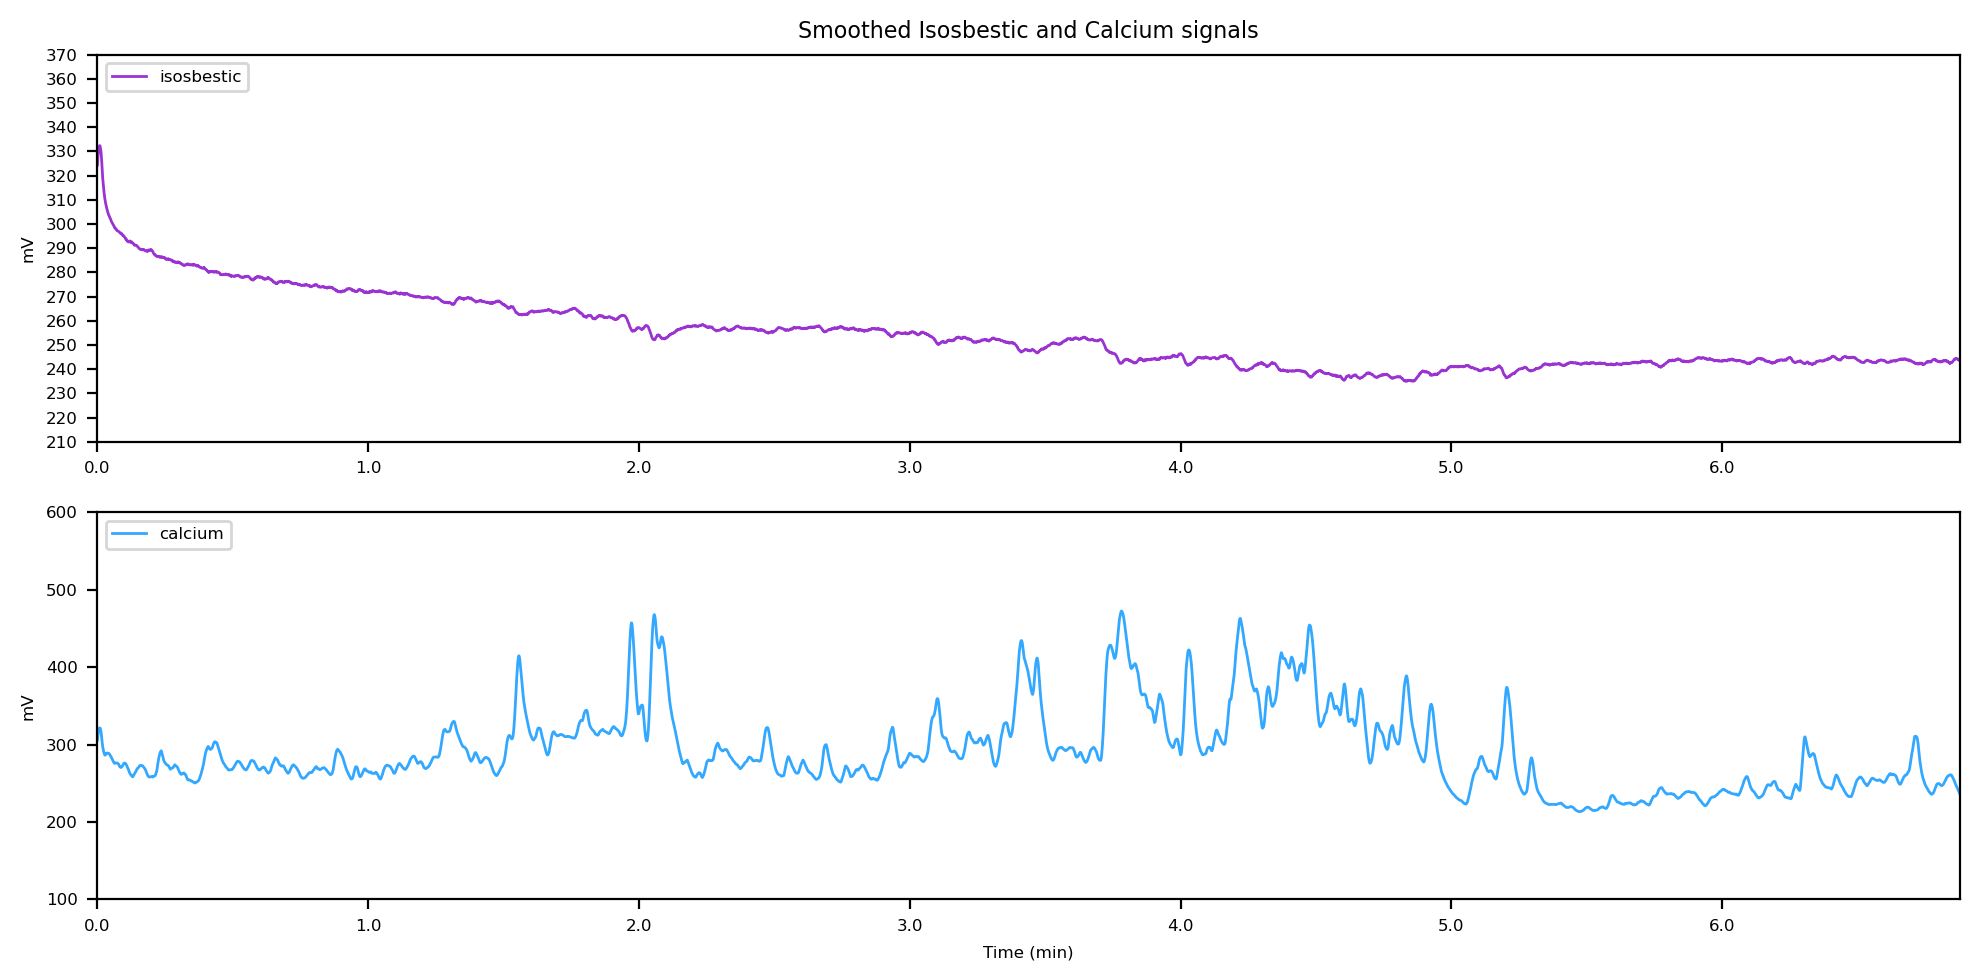

In [7]:
x1, isosbestic_smoothed, calcium_smoothed = spp.smooth(x0, isosbestic, calcium, **args)

## Estimate the baseline of the signals

The third step of the pre-processing pipeline is to determine the baseline of the respective signals.
The function _spp.find_baseline_and_crop_ allows you to do that. The main parameters to modify here is : _method_ which corresponds to the method that will be used by the algorithm to estimate the baseline.

In this version of the code, 2 methods using different algorithms are available (The second one giving better results) : 
- Centered Moving Average algorithm (method = "ma")
- Asymmetric Least Squares Smoothing algorithm (method = "als")

If the Centered Moving Average is chosen, the main parameter to change would be :
- args["moving_average_window"]. It is set by default to 60*sampling_rate of the recording.


If the Asymmetric Least Squares Smoothing algorithm in chosen, the main parameters to change would be :
- args["lambda"]. This parameter defines the smoothness, it is set by default to 10^11 (10^2 ≤ l ≤ 10^11)
- args["p"]. This parameter defines the asymmetry, it is set by default to 0.01 (0.001 ≤ p ≤ 0.1)

Additionally, this function also crops the data at the begining and the end of the recording if desired. This can be modified by :
- args["cropping_window"]. This parameters is set by default to 30s. The data will automatically be cropped 30s at the begining and the end of the recording.

Finally, the _spp.baseline_correction_ function sustracts the signal from the baseline to correct for the decay and bleaching.


Starting baseline computation for Isosbestic and Calcium signals !

Starting baseline correcion for Isosbestic and Calcium signals !


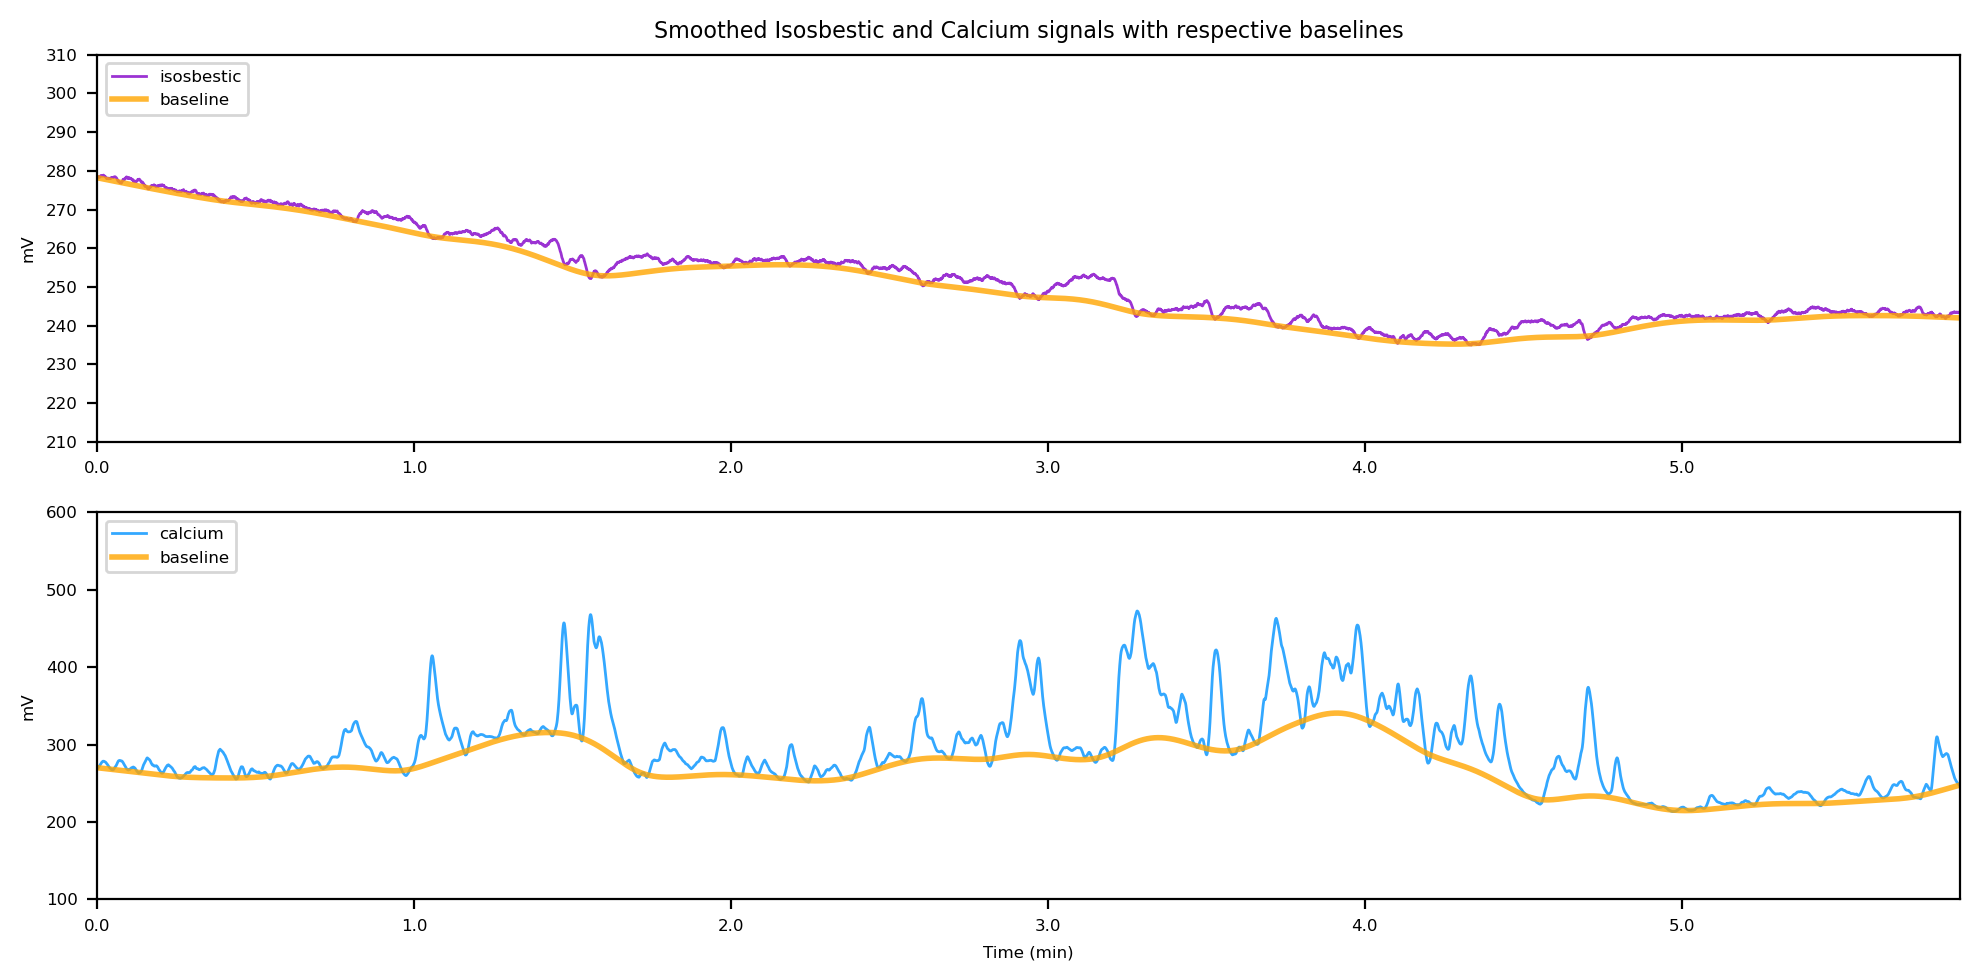

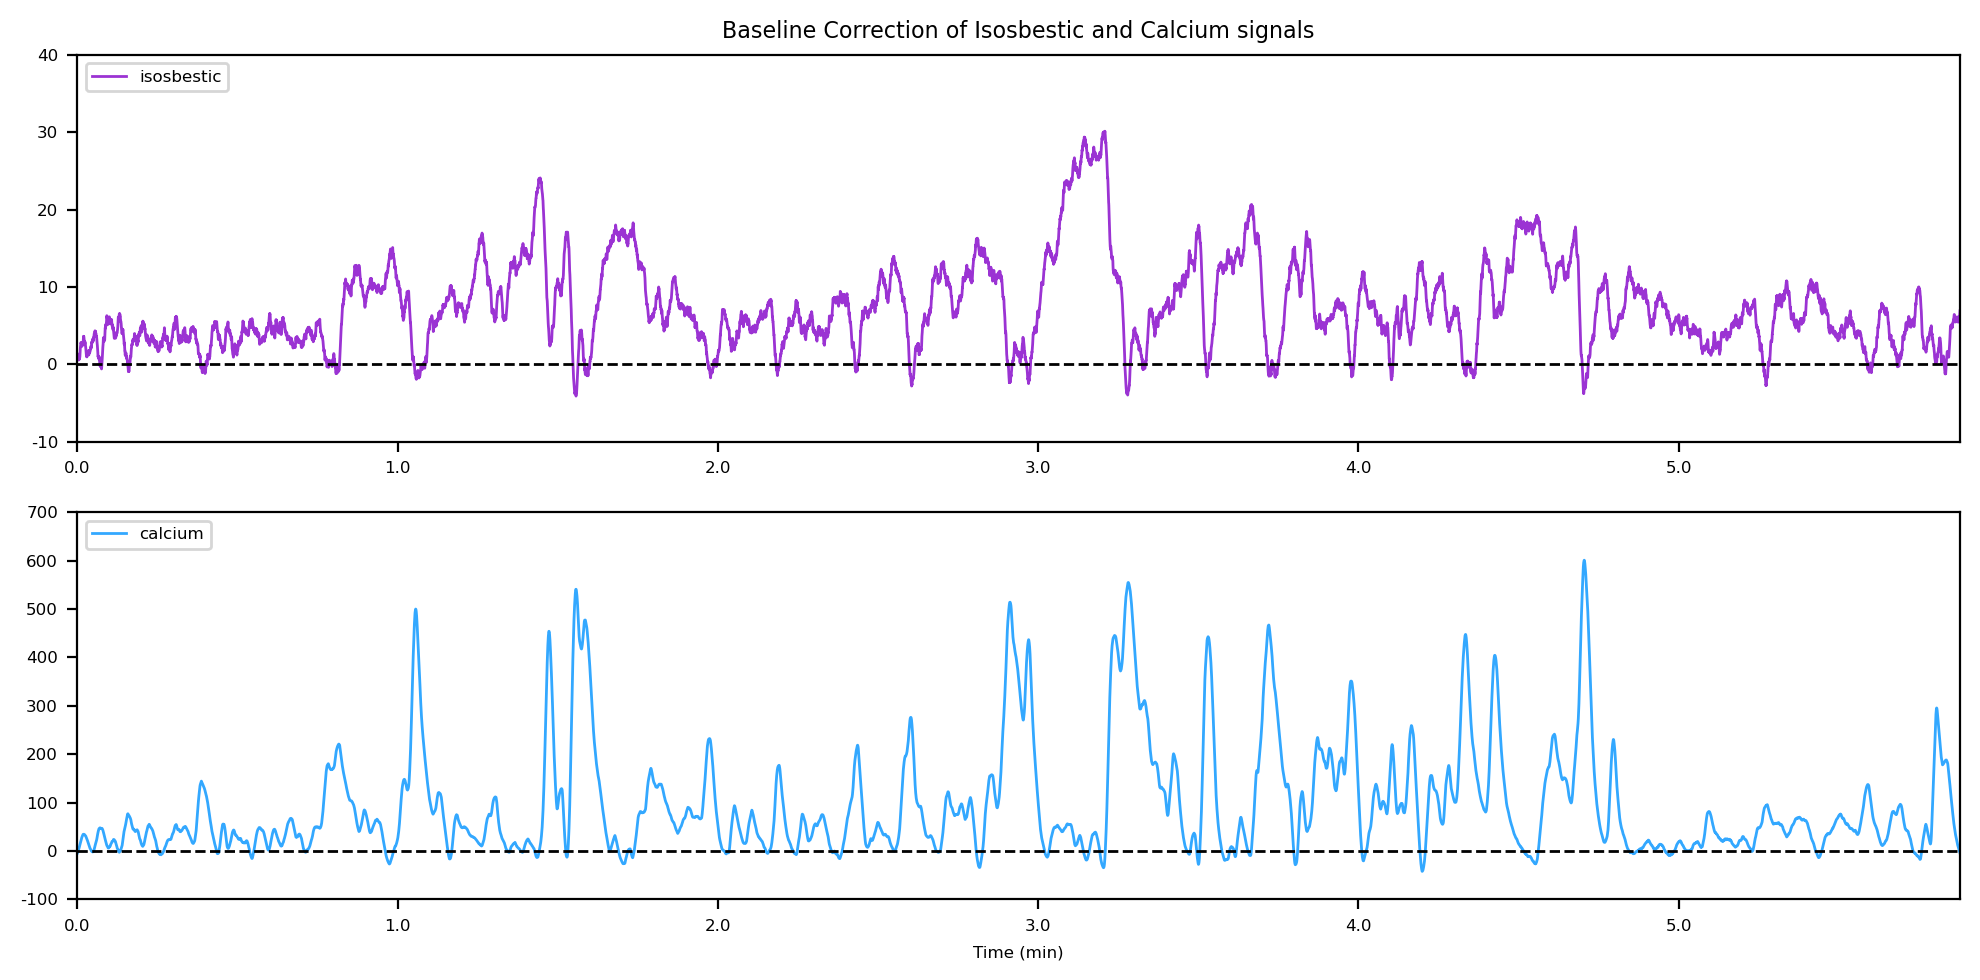

In [8]:
x2, isosbestic_cropped, calcium_cropped, function_isosbestic, function_calcium = spp.find_baseline_and_crop(x1, isosbestic_smoothed, calcium_smoothed, method="als", **args)
isosbestic_corrected, calcium_corrected = spp.baseline_correction(x2, isosbestic_cropped, calcium_cropped, function_isosbestic, function_calcium, **args)

## Standardization of the signal

The fourth step of the pre-processing pipeline is to normalize the signals using standardization (signal - mean / standard deviation).
The function _spp.standardization_ allows you to do that.


Starting standardization for Isosbestic and Calcium signals !


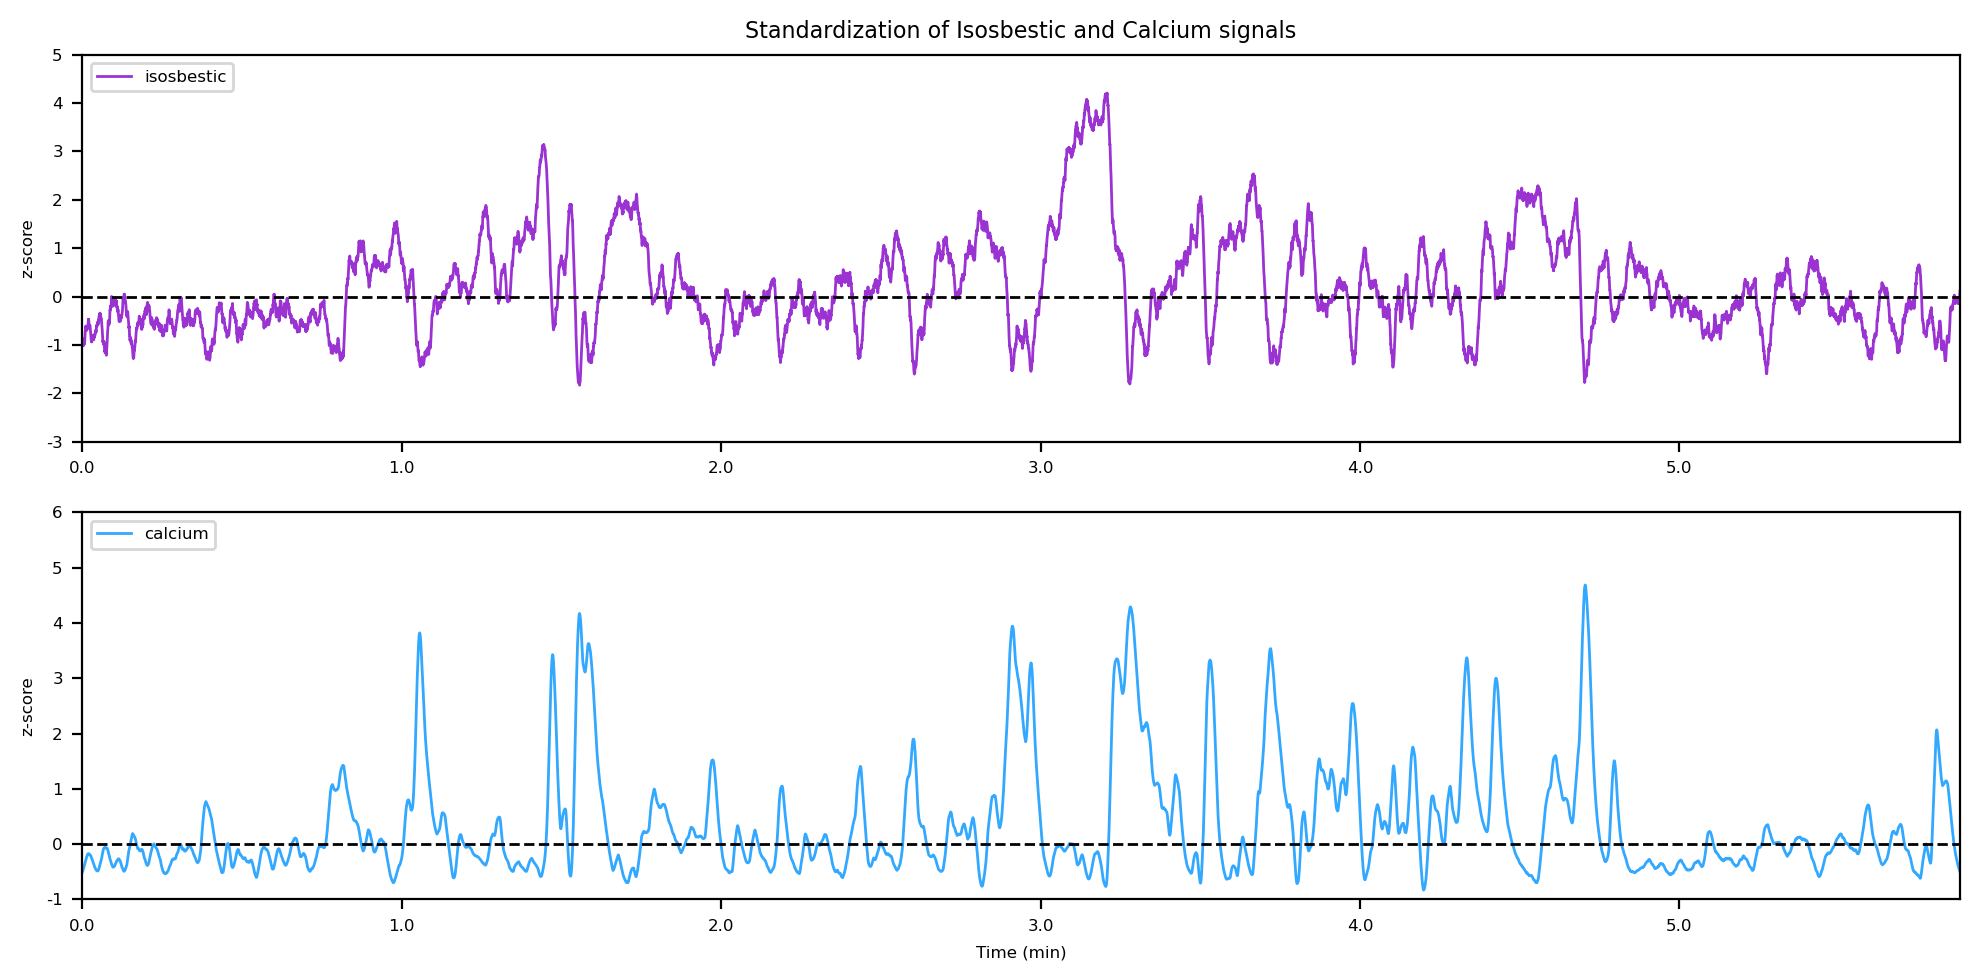

In [10]:
isosbestic_standardized, calcium_standardized = spp.standardization(x2, isosbestic_corrected, calcium_corrected, **args)

## Inter-channel regression & Alignement of the two signals

The fifth step of the pre-processing pipeline is align the two signals together using regression.
The function _spp.interchannel_regression_ allows you to do that. The main parameters to modify here is : _args["photometry_pp"]["regression"]_ which corresponds to the method that will be used by the algorithm to perform the regression.

In this version of the code, 2 methods using different algorithms are available to perform the regression (both give similar results) : 
- Least Absolute Shrinkage and Selection Operator (LASSO) args["photometry_pp"]["regression"] = "lasso"
- Linear Regression

Finally, the _spp.align_channels_ function displays the two signals aligned using the results of the regression fit.


Starting interchannel regression and alignement for Isosbestic and Calcium signals !


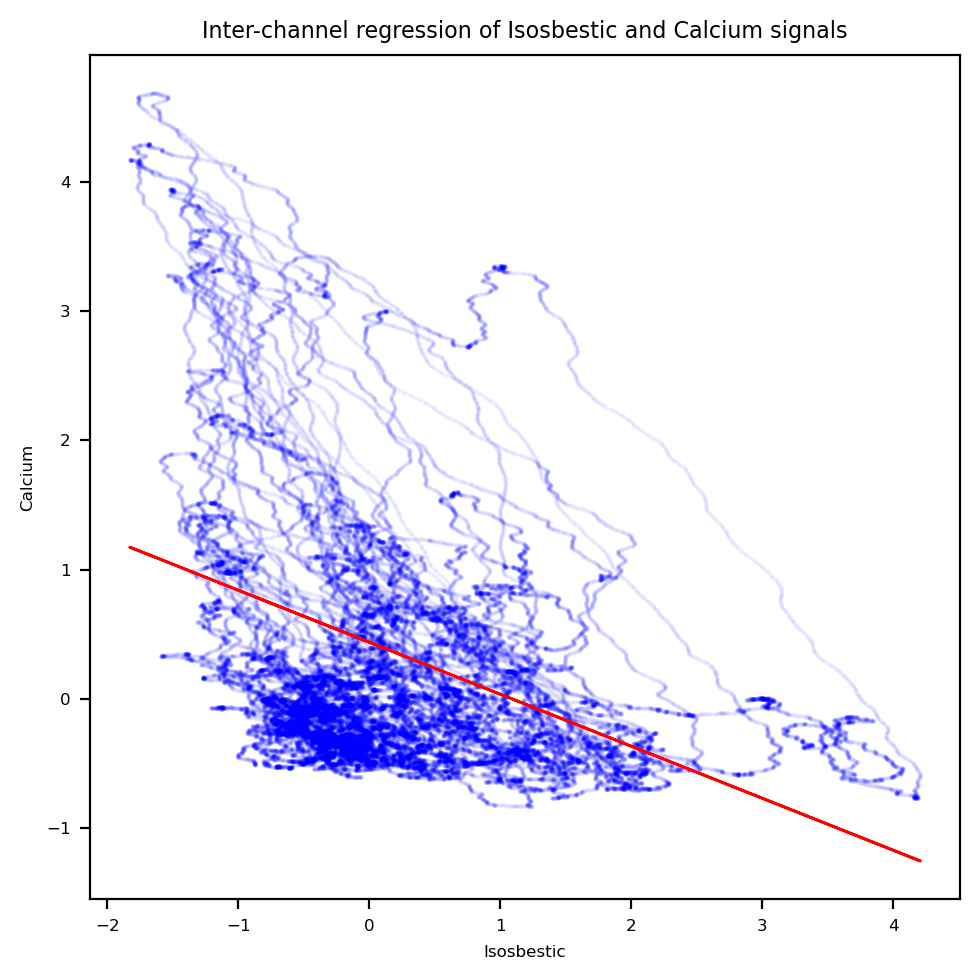

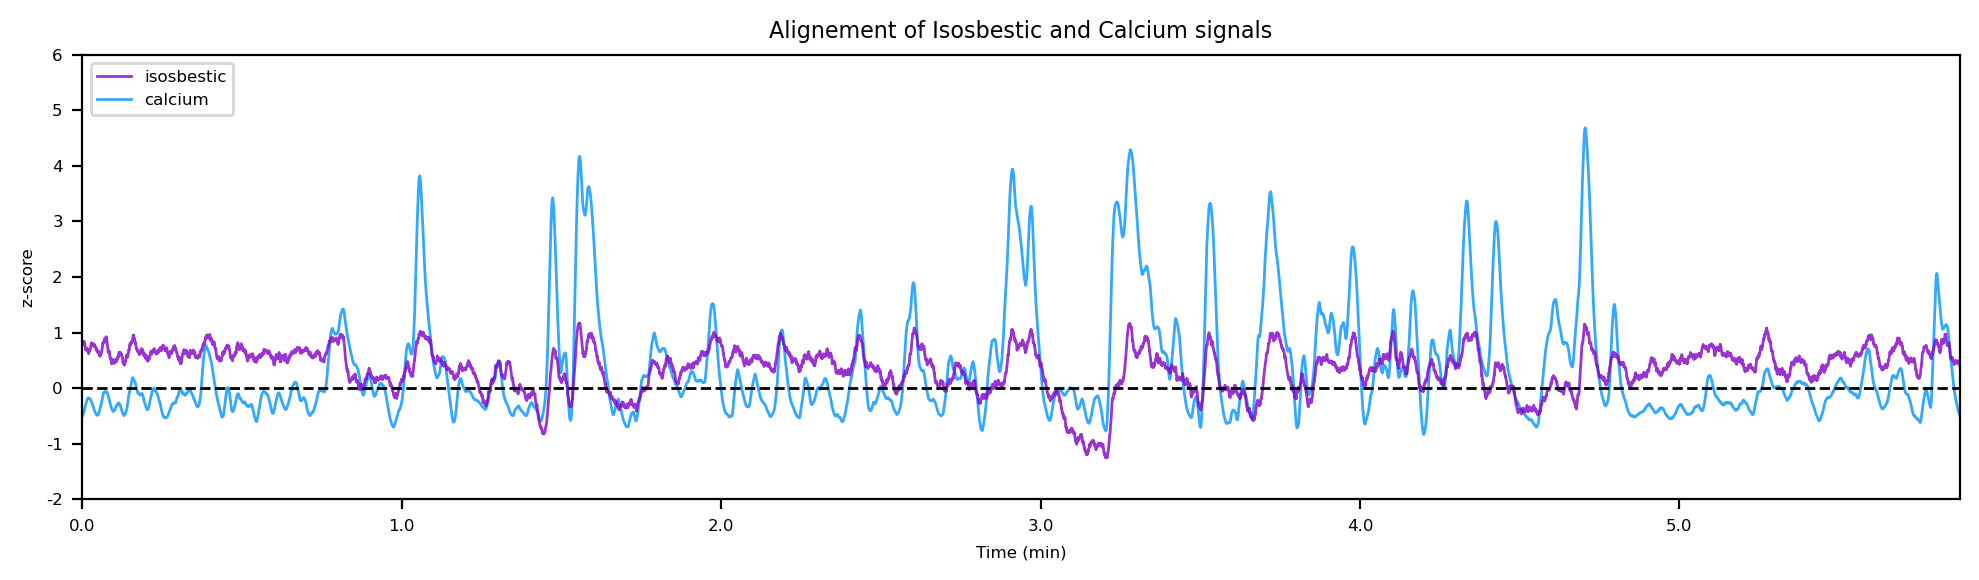

In [11]:
isosbestic_fitted = spp.interchannel_regression(isosbestic_standardized, calcium_standardized, **args)      
spp.align_channels(x2, isosbestic_fitted, calcium_standardized, **args)

## Inter-channel regression & Alignement of the two signals

The last step of the pre-processing pipeline is to substract the aligned signals to get the relative changes in fluorescence over time (dF/F).
The function _spp.dFF_ allows you to do that.


Starting the computation of dF/F !


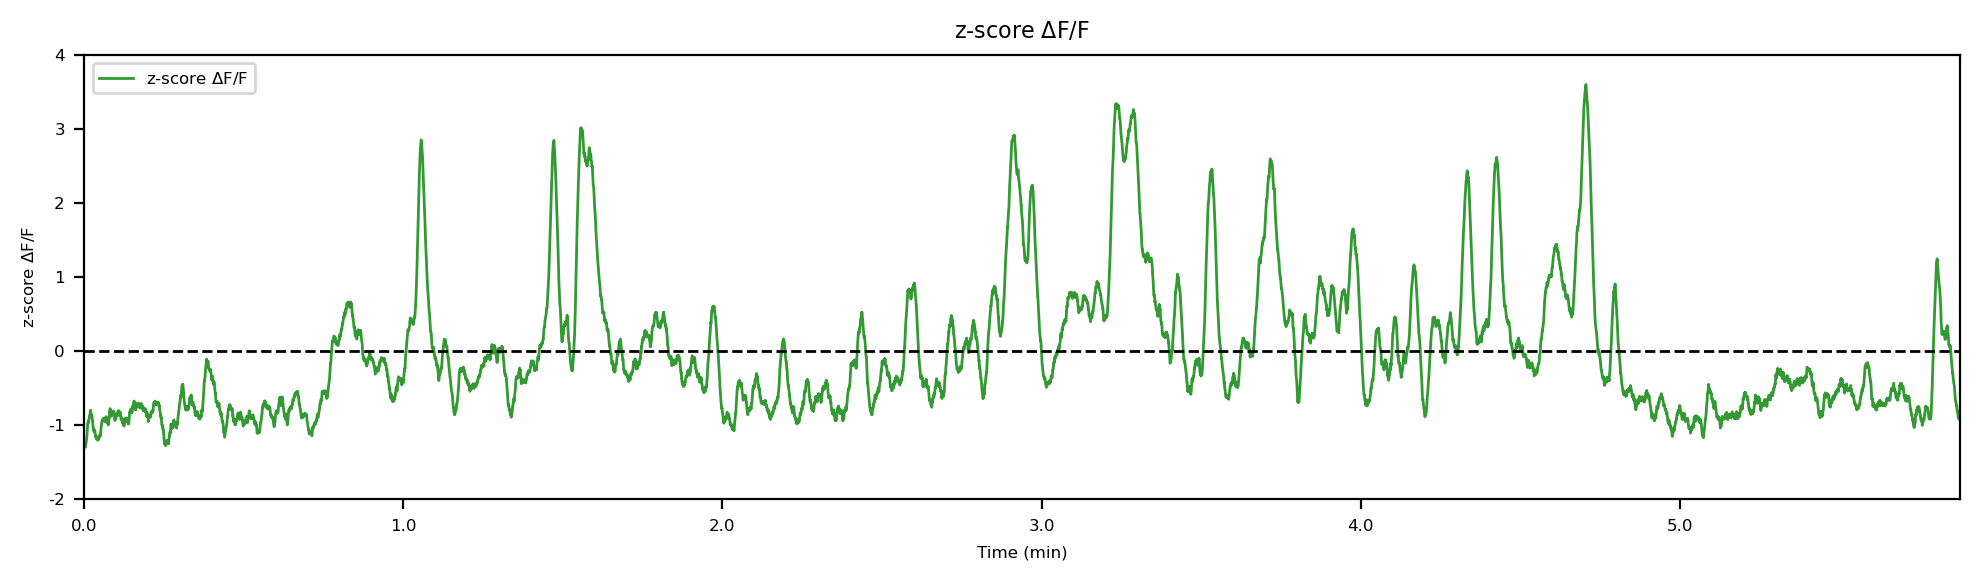

In [12]:
dF = spp.dFF(x2, isosbestic_fitted, calcium_standardized, **args)

# Aknowledgements

Most of the code was inspired by this [Martianova E. et al., 2019](https://www.jove.com/t/60278/multi-fiber-photometry-to-record-neural-activity-freely-moving)
The code made by Ekaterina Martianova can be found [here](https://github.com/katemartian/Photometry_data_processing)

The Asymmetric Least Squares Smoothing algorithm for the determination of the baseline was inspired by this paper [P. Eilers and H. Boelens, 2005](https://www.researchgate.net/publication/228961729_Baseline_Correction_with_Asymmetric_Least_Squares_Smoothing)

# Contact

If you need help or wish to contact me with a question write to : thomas.topilko@gmail.com

# Author

Thomas TOPILKO